In [33]:
# 库模块导入
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [34]:
# 加载并规范化CIFAR10
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 超参数1
batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [35]:
# Resnet-18模型-有残差

#定义残差块
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super(ResBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.relu = nn.ReLU()
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        out = self.left(x)
        out = out + self.shortcut(x)
        out = self.relu(out)

        return out

# 定义Resnet-18网络
class Resnet18(nn.Module):
    def __init__(self):
        super(Resnet18, self).__init__()
        # 卷积层输入
        self.pre = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=7,stride=2,padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        )

        # 中间4个残差块
        # 64x56x56-->64x56x56
        self.layer1=nn.Sequential(
            ResBlock(64,64,3,1),
            ResBlock(64,64,3,1)
        )
        # 64x56x56-->128*28*28
        self.layer2=nn.Sequential(
            ResBlock(64,128,3,2),
            ResBlock(128,128,3,1)
        )
        # 128*28*28-->256*14*14
        self.layer3=nn.Sequential(
            ResBlock(128,256,3,2),
            ResBlock(256,256,3,1)
        )
        # 256*14*14-->512x7x7
        self.layer4=nn.Sequential(
            ResBlock(256,512,3,2),
            ResBlock(512,512,3,1)
        )

        # 全连接层输出
        # 512x7x7-->512x1x1
        self.avgpool=nn.AdaptiveMaxPool2d(output_size=(1,1))
        self.flat=nn.Flatten()
        self.linear=nn.Linear(512,10)

    def forward(self,x):
        x = self.pre(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.flat(x)
        x = self.linear(x)
        return x

In [40]:
# Resnet-18模型-无残差

#定义基础块
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1):
        super(BasicBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.left(x)
        out = self.relu(out)

        return out

# 定义Resnet-18网络
class Resnet18_none(nn.Module):
    def __init__(self):
        super(Resnet18_none, self).__init__()
        # 卷积层输入
        self.pre = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=7,stride=2,padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        )

        # 中间4个残差块
        # 64x56x56-->64x56x56
        self.layer1=nn.Sequential(
            BasicBlock(64,64,3,1),
            BasicBlock(64,64,3,1)
        )
        # 64x56x56-->128*28*28
        self.layer2=nn.Sequential(
            BasicBlock(64,128,3,2),
            BasicBlock(128,128,3,1)
        )
        # 128*28*28-->256*14*14
        self.layer3=nn.Sequential(
            BasicBlock(128,256,3,2),
            BasicBlock(256,256,3,1)
        )
        # 256*14*14-->512x7x7
        self.layer4=nn.Sequential(
            BasicBlock(256,512,3,2),
            BasicBlock(512,512,3,1)
        )

        # 全连接层输出
        # 512x7x7-->512x1x1
        self.avgpool=nn.AdaptiveMaxPool2d(output_size=(1,1))
        self.flat=nn.Flatten()
        self.linear=nn.Linear(512,10)

    def forward(self,x):
        x = self.pre(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.flat(x)
        x = self.linear(x)
        return x


In [41]:
# 创建网络模型
device = torch.device("cuda:0")
# net = Resnet18() # 有残差
net = Resnet18_none() # 无残差
net = net.to(device)

In [42]:
# 定义绘制loss曲线函数
def DrawLoss(file_name, label_name):

    with open(file_name, 'r') as f:
        raw_data = f.read()
        # [-1:1]是为了去除文件中的前后中括号"[]"
        data = raw_data[1:-1].split(",")

    y_loss = np.asfarray(data, float)
    x_loss = range(len(y_loss))
    plt.figure()

    # 去除顶部和右侧边框
    ax = plt.axes()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.xlabel('iters')    # x轴标签
    plt.ylabel('loss')     # y轴标签

    # 以x_loss为横坐标，y_loss为纵坐标，曲线宽度为1，实线，增加标签，训练损失，
    # 默认颜色，如果想更改颜色，可以增加参数color='red',这是红色。
    plt.plot(x_loss, y_loss, linewidth=1, linestyle="solid", label=label_name)
    plt.legend()
    plt.title('Loss curve')
    plt.show()


In [43]:
# 定义损失函数和优化器
import torch.optim as optim

# 使用交叉熵损失函数
criterion = nn.CrossEntropyLoss()

# 超参数2
learning_rate = 0.03

# 使用优化器
# 超参数3
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

In [44]:
# 训练网络

# 记录训练loss
train_loss = []
# 开始训练
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        train_loss.append(running_loss)

        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')


[1,   200] loss: 2.167
[1,   400] loss: 1.979
[2,   200] loss: 1.864
[2,   400] loss: 1.718
[3,   200] loss: 1.581
[3,   400] loss: 1.494
[4,   200] loss: 1.389
[4,   400] loss: 1.335
[5,   200] loss: 1.262
[5,   400] loss: 1.206
[6,   200] loss: 1.158
[6,   400] loss: 1.118
[7,   200] loss: 1.062
[7,   400] loss: 1.049
[8,   200] loss: 1.009
[8,   400] loss: 0.980
[9,   200] loss: 0.948
[9,   400] loss: 0.947
[10,   200] loss: 0.884
[10,   400] loss: 0.880
[11,   200] loss: 0.844
[11,   400] loss: 0.863
[12,   200] loss: 0.819
[12,   400] loss: 0.800
[13,   200] loss: 0.765
[13,   400] loss: 0.778
[14,   200] loss: 0.714
[14,   400] loss: 0.731
[15,   200] loss: 0.675
[15,   400] loss: 0.704
[16,   200] loss: 0.669
[16,   400] loss: 0.674
[17,   200] loss: 0.627
[17,   400] loss: 0.636
[18,   200] loss: 0.582
[18,   400] loss: 0.601
[19,   200] loss: 0.566
[19,   400] loss: 0.578
[20,   200] loss: 0.513
[20,   400] loss: 0.546
[21,   200] loss: 0.496
[21,   400] loss: 0.515
[22,   200

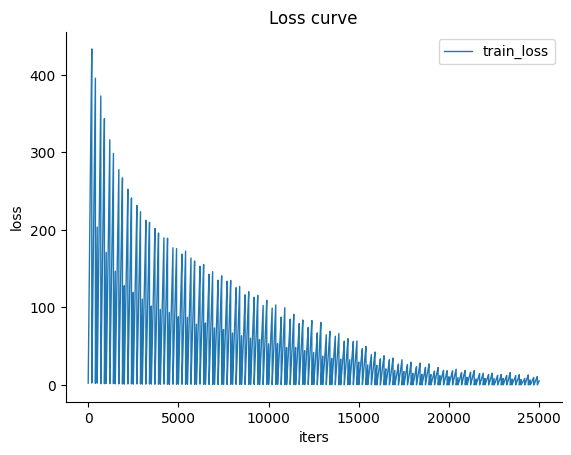

In [45]:
# 绘制train loss曲线

file_name_train = 'train_logs_batch4_lr0.005.txt'
with open(file_name_train,'w') as train_los:
    train_los.write(str(train_loss))

DrawLoss(file_name_train, "train_loss")

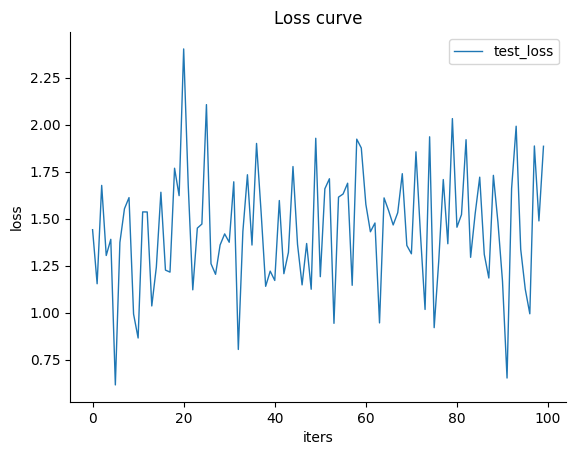

Accuracy of the network on the 10000 test images: 75 %


In [46]:
# 测试网络
correct = 0
total = 0

# 记录测试loss
test_loss = []

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # calculate outputs by running images through the network
        outputs = net(images)

        loss = criterion(outputs, labels)
        test_loss.append(loss.item())

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


# 绘制test loss曲线
file_name_test = 'test_logs_batch4_lr0.005.txt'
with open(file_name_test,'w') as test_los:
    test_los.write(str(test_loss))

DrawLoss(file_name_test, "test_loss")


# 整体精度
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [47]:
# 分类
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

# 在每个类别上的精度
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of plane : 79 %
Accuracy of   car : 93 %
Accuracy of  bird : 65 %
Accuracy of   cat : 48 %
Accuracy of  deer : 67 %
Accuracy of   dog : 68 %
Accuracy of  frog : 86 %
Accuracy of horse : 90 %
Accuracy of  ship : 89 %
Accuracy of truck : 86 %
